In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

In [18]:
# mod 2 inverse function
# adapted from https://towardsdatascience.com/find-the-inverse-of-a-matrix-using-python-3aeb05b48308

# write rows in reduced row echelon (rref) form
def invert_matrix(M):
    # store dimension
    n = M.shape[0]
    
    # A must be square with non-zero determinant
    # assert np.linalg.det(M) != 0

    # identity matrix with same shape as A
    I = np.identity(n=n, dtype = int)

    # form the augmented matrix by concatenating A and I
    M = np.concatenate((M, I), axis=1)

    # move all zeros to buttom of matrix
    M = np.concatenate((M[np.any(M != 0, axis=1)], M[np.all(M == 0, axis=1)]), axis=0)

    # iterate over matrix rows
    for i in range(0, n):

        # initialize row-swap iterator
        j = 1

        # select pivot value
        pivot = M[i][i]

        # find next non-zero leading coefficient
        while pivot == 0 and i + j < n:
            # perform row swap operation
            M[[i, i + j]] = M[[i + j, i]]

            # incrememnt row-swap iterator
            j += 1

            # get new pivot
            pivot = M[i][i]

        # if pivot is zero, remaining rows are all zeros
        if pivot == 0:
            # return inverse matrix
            return M[:, n:]

        # extract row
        # row = M[i]

        # get 1 along the diagonal
        # M[i] = row / pivot

        # iterate over all rows except pivot to get augmented matrix into reduced row echelon form
        for j in [k for k in range(0, n) if k != i]:
            # subtract current row from remaining rows
            M[j] = (M[j] - M[i] * M[j][i]) % 2

    # return inverse matrix
    return M[:, n:]

In [27]:
# obtain the (symplectic) parity check matrices H_XZ: dim 2*((n-k)*n) -> n * (2*(n-k)): 

# obtain the logical operator: the complete set of k logical-X + k logical-Z: each dim k*(2n)-> k*n:
# follow the procedure in Chapter 4 of Gottesman’s thesis: https://thesis.library.caltech.edu/2900/2/THESIS.pdf
# H_XZ = 

# logical operator example: 
# on 7-qubit:
# n,k,r follow the notation in Gottesman's thesis:
n = 7
k = 1
r = 3
H_XZ = np.array([[1,1,1,1,0,0,0,0,0,0,0,0,0,0],\
                [1,1,0,0,1,1,0,0,0,0,0,0,0,0],\
                [1,0,1,0,1,0,1,0,0,0,0,0,0,0],\
                [0,0,0,0,0,0,0,1,1,1,1,0,0,0],\
                [0,0,0,0,0,0,0,1,1,0,0,1,1,0],\
                [0,0,0,0,0,0,0,1,0,1,0,1,0,1]])

# step1: transform into the standard form:
# Gaussian elimination on certain blocks:
H_Ainv = invert_matrix(H_XZ[0:r,0:r])
H_Einv = invert_matrix(H_XZ[r:n-k, n+r:2*n-k])
print(H_Ainv)
print(H_Einv)
H_XZ1 = np.zeros((n-k, 2*n), dtype = int)
H_XZ1[0:r, :] = H_Ainv @ H_XZ[0:r, :]
H_XZ1[r:n-k, :] = H_Einv @ H_XZ[r:n-k, :]
H_XZ1 = H_XZ1 % 2
print(H_XZ1)

# now have the standard form H_XZ1, for example:

H_XZ1_check = np.array([[1,0,0,1,0,1,1,0,0,0,0,0,0,0],\
                [0,1,0,1,1,0,1,0,0,0,0,0,0,0],\
                [0,0,1,1,1,1,0,0,0,0,0,0,0,0],\
                [0,0,0,0,0,0,0,1,1,1,1,0,0,0],\
                [0,0,0,0,0,0,0,1,0,1,0,1,0,1],\
                [0,0,0,0,0,0,0,0,1,1,0,0,1,1]])
print(H_XZ1 == H_XZ1_check)


# step2: solve the logical operator by different matrix section in the standard form:
# notice: k sets of X/Z logical operators in general
logicals_X = np.zeros((k, 2*n),dtype = int)
logicals_Z = np.zeros((k, 2*n),dtype = int)

# logical_X: (U1 U2 U3 | V1 V2 V3)
# U1 = 0 (k*r), U2 = E^T (k*(n-k-r)), U3 = I (k*k), 
# V1 = E^T*C_1^T + C_2^T (k*r), V2 = 0 (k*(n-k-r)), V3 = 0 (k*k):
E = H_XZ1[r:n-k, 2*n-k:2*n]
C_1 = H_XZ1[0:r, n+r:2*n-k]
C_2 = H_XZ1[0:r, 2*n-k:2*n]
A_2 = H_XZ1[0:r, n-k:n]
logicals_X[0:k,0:r] = np.zeros((k,r),dtype=int)
logicals_X[0:k,r:n-k] = np.transpose(E)
logicals_X[0:k,n-k:n] = np.eye(k,dtype=int)
logicals_X[0:k,n:n+r] = np.transpose(E)@np.transpose(C_1)+np.transpose(C_2)
logicals_X[0:k,n+r:2*n-k] = np.zeros((k,n-k-r),dtype=int)
logicals_X[0:k,2*n-k:2*n] = np.zeros((k,k),dtype=int)

# logical_Z: (U1' U2' U3' | V1' V2' V3')
# U1' = 0 (k*r), U2' = 0 (k*(n-k-r)), U3' = 0 (k*k), 
# V1' = A_2^T (k*r), V2' = 0 (k*(n-k-r)), V3' = I (k*k):
logicals_Z[0:k,0:r] = np.zeros((k,r),dtype=int)
logicals_Z[0:k,r:n-k] = np.zeros((k,n-k-r),dtype=int)
logicals_Z[0:k,n-k:n] = np.zeros((k,k),dtype=int)
logicals_Z[0:k,n:n+r] = np.transpose(A_2)
logicals_Z[0:k,n+r:2*n-k] = np.zeros((k,n-k-r),dtype=int)
logicals_Z[0:k,2*n-k:2*n] = np.eye(k,dtype=int)
logicals_X = logicals_X % 2
logicals_Z = logicals_Z % 2
print(logicals_X)
print(logicals_Z)
print("X stabilizers:",logicals_X[:,0:n])
print("Z stabilizers:",logicals_Z[:,n:2*n])
print("equvalient to [1]*n (mod S), (S denotes stabilizer group)")

[[1 1 1]
 [1 0 1]
 [1 1 0]]
[[1 0 0]
 [0 0 1]
 [0 1 1]]
[[1 0 0 1 0 1 1 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 1 0 0 1 1]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]
[[0 0 0 0 1 1 1 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 1 1 0 0 0 0 1]]
X stabilizers: [[0 0 0 0 1 1 1]]
Z stabilizers: [[1 1 0 0 0 0 1]]
equvalient to [1]*n (mod S), (S denotes stabilizer group)


In [28]:
# function for calculating logical operators:
def logical_from_Hparity(H_XZ, n, k, r):

    # step1: transform into the standard form:
    # Gaussian elimination on certain blocks:
    H_Ainv = invert_matrix(H_XZ[0:r,0:r])
    H_Einv = invert_matrix(H_XZ[r:n-k, n+r:2*n-k])
    H_XZ1 = np.zeros((n-k, 2*n), dtype = int)
    H_XZ1[0:r, :] = H_Ainv @ H_XZ[0:r, :]
    H_XZ1[r:n-k, :] = H_Einv @ H_XZ[r:n-k, :]
    H_XZ1 = H_XZ1 % 2

    # step2: solve the logical operator by different matrix section in the standard form:
    # notice: k sets of X/Z logical operators in general
    logicals_X = np.zeros((k, 2*n),dtype = int)
    logicals_Z = np.zeros((k, 2*n),dtype = int)

    # logical_X: (U1 U2 U3 | V1 V2 V3)
    # U1 = 0 (k*r), U2 = E^T (k*(n-k-r)), U3 = I (k*k), 
    # V1 = E^T*C_1^T + C_2^T (k*r), V2 = 0 (k*(n-k-r)), V3 = 0 (k*k):
    E = H_XZ1[r:n-k, 2*n-k:2*n]
    C_1 = H_XZ1[0:r, n+r:2*n-k]
    C_2 = H_XZ1[0:r, 2*n-k:2*n]
    A_2 = H_XZ1[0:r, n-k:n]
    logicals_X[0:k,0:r] = np.zeros((k,r),dtype=int)
    logicals_X[0:k,r:n-k] = np.transpose(E)
    logicals_X[0:k,n-k:n] = np.eye(k,dtype=int)
    logicals_X[0:k,n:n+r] = np.transpose(E)@np.transpose(C_1)+np.transpose(C_2)
    logicals_X[0:k,n+r:2*n-k] = np.zeros((k,n-k-r),dtype=int)
    logicals_X[0:k,2*n-k:2*n] = np.zeros((k,k),dtype=int)

    # logical_Z: (U1' U2' U3' | V1' V2' V3')
    # U1' = 0 (k*r), U2' = 0 (k*(n-k-r)), U3' = 0 (k*k), 
    # V1' = A_2^T (k*r), V2' = 0 (k*(n-k-r)), V3' = I (k*k):
    logicals_Z[0:k,0:r] = np.zeros((k,r),dtype=int)
    logicals_Z[0:k,r:n-k] = np.zeros((k,n-k-r),dtype=int)
    logicals_Z[0:k,n-k:n] = np.zeros((k,k),dtype=int)
    logicals_Z[0:k,n:n+r] = np.transpose(A_2)
    logicals_Z[0:k,n+r:2*n-k] = np.zeros((k,n-k-r),dtype=int)
    logicals_Z[0:k,2*n-k:2*n] = np.eye(k,dtype=int)
    logicals_X = logicals_X % 2
    logicals_Z = logicals_Z % 2

    return (logicals_X, logicals_Z)

In [32]:
n = 7
k = 1
r = 3
H_XZ = np.array([[1,1,1,1,0,0,0,0,0,0,0,0,0,0],\
                [1,1,0,0,1,1,0,0,0,0,0,0,0,0],\
                [1,0,1,0,1,0,1,0,0,0,0,0,0,0],\
                [0,0,0,0,0,0,0,1,1,1,1,0,0,0],\
                [0,0,0,0,0,0,0,1,1,0,0,1,1,0],\
                [0,0,0,0,0,0,0,1,0,1,0,1,0,1]])
logicals_X = logical_from_Hparity(H_XZ, n, k, r)[0]
logicals_Z = logical_from_Hparity(H_XZ, n, k, r)[1]
print(logicals_X)
print(logicals_Z)

[[0 0 0 0 1 1 1 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 1 1 0 0 0 0 1]]


In [10]:
def succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: numpy array]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    B = B_orig.copy()
    logicals = np.copy(logicals_in)
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    logic_succ = True
    for q in loss_inds:
        ## correct logical operators
        if logicals.ndim == 1:
            if logicals[q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals = (logicals+Sx_mat[st_ind[0],:]) % 2
                else:
                    logic_succ = False
                    break
        else:
            for i_log in range(np.size(logicals,0)):
                if logicals[i_log,q]>0:            
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log,:] = (logicals[i_log,:]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logic_succ = False
                        # logicals[i_log,:] = np.zeros(np.size(logicals,1))
                        break
            if not logic_succ:
                break
            
        ## update stabilizer group
        ## first: update graph
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}

        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                break

    ## check if logical error happens
    if logicals.ndim == 1:
        logic_sum = np.sum(logicals)> 0
    else:
        logic_sum = np.sum(np.sum(logicals,axis=1))> (np.size(logicals,0)-1)
        
    succ_fail = 0 # default value: failure
    if Ns_remain > 0 and logic_sum and logic_succ:
        succ_fail = 1 # success

    return succ_fail

## code breakdown illustration
Here we use 7-qubit code as an example and show how the algorithm performs.

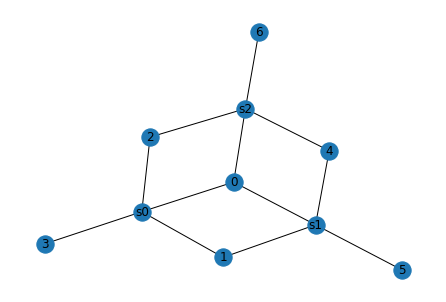

list of erased qubits: [0 3]
-------------------------
erased qubit: 0
s0 is applied to log op.
log op. is  [0. 0. 1. 1. 0. 0. 1.]
stabilizer ops. are
[[0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0.]]


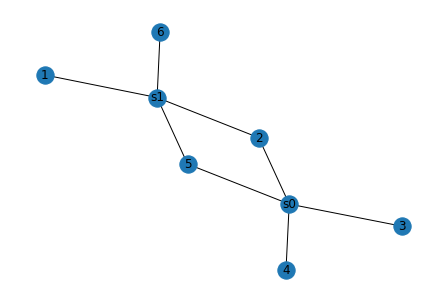

-------------------------
erased qubit: 3
s1 is applied to log op.
log op. is  [0. 0. 0. 0. 1. 1. 1.]
stabilizer ops. are
[[0. 1. 1. 0. 0. 1. 1.]]


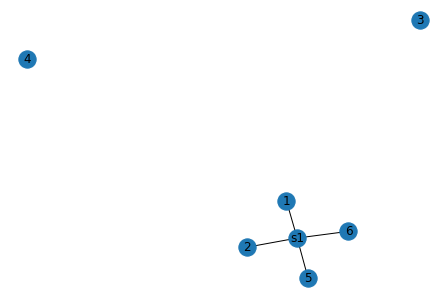

-------------------------
success!


In [11]:
## 7-qubit stabilizer matrix
Sx_mat = np.array([[1,1,1,1,0,0,0],\
            [1,1,0,0,1,1,0],\
            [1,0,1,0,1,0,1]])

N = np.size(Sx_mat,1) # number of data qubits 
Ns = np.size(Sx_mat,0) # number of stabilizers 

## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(np.size(Sx_mat,0)):
    qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

nx.draw(B_orig,  with_labels=True)
plt.show()
## logical operator
logical = np.ones(N)

p = 0.3 # loss probability
## generate an instance of loss events
loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
print("list of erased qubits:", loss_inds)
print("-------------------------")

B = B_orig.copy()
s_nodes_set = set(np.copy(s_nodes))

Ns_remain = len(s_nodes_set)
q_remain = list(set(B.nodes())-s_nodes_set)
node_list = list(s_nodes_set) + q_remain
adj_mat_new = nx.to_numpy_array(B, nodelist = node_list)
Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:]

logic_succ = True
for q in loss_inds:
    print("erased qubit:", q)
    if logical[q]>0:            
        st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
        if len(st_ind)>0:
            print("s%d is applied to log op." % st_ind[0])
            # print("sum is ", ((logical+Sx_mat[st_ind[0],:]) % 2))
            logical = ((logical+Sx_mat[st_ind[0],:]) % 2)
        else:
            logic_succ = False
            break
           
    print("log op. is ", logical)
    if q in B:
        sq = [n for n in B.neighbors(q)]
        if len(sq)==1:
            B.remove_nodes_from(sq)
            s_nodes_set -= set(sq)
        elif len(sq)>1:
            double_edgs = []
            for i in range(len(sq)-1):
                n0 = set(B.neighbors(sq[i]))
                n1 = set(B.neighbors(sq[i+1]))
                rep_qs = n0.intersection(n1)
                q0 = list(set(n0)-rep_qs)
                q1 = list(set(n1)-rep_qs)
                double_edgs += [(sq[i], e) for e in q0]
                double_edgs += [(sq[i], e) for e in q1]
            G = nx.Graph()
            G.add_nodes_from(sq[:-1])
            G.add_edges_from(double_edgs)
            sq_remain = list(s_nodes_set-set(sq))
            for s in sq_remain:
                G.add_edges_from([(s, e) for e in B.neighbors(s)])
            B = G
            s_nodes_set -= {sq[-1]}
        
        Ns_remain = len(s_nodes_set)
        if Ns_remain> 0:
            q_remain = list(set(B.nodes())-s_nodes_set)
            node_list = list(s_nodes_set) + q_remain
            adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
            Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,1]
            Sx_red = Sx_red[:,keep_cols]
            q_remain = np.array(q_remain)[keep_cols]
            Sx_mat = np.zeros((Ns_remain,N))
            Sx_mat[:,q_remain] = Sx_red
        else:
            Sx_mat = []
            break
            
        print("stabilizer ops. are")
        print(Sx_mat)
            # print(s_nodes_set,q_remain)

    nx.draw(B,  with_labels=True)
    plt.show()
    print("-------------------------")

## check if logical error happens
logic_sum = np.sum(logical)> 0        
succ_fail = 0 # default value: failure
if Ns_remain > 0 and logic_sum and logic_succ:
    succ_fail = 1 # success
if succ_fail:
    print("success!")
else:
    print("logical error!")


## Example 1: single layer 7-qubit code

#### Sanity check 1: 7-qubit code

In [205]:
H_XZ = np.array([[1,1,1,1,0,0,0,0,0,0,0,0,0,0],\
                [1,1,0,0,1,1,0,0,0,0,0,0,0,0],\
                [1,0,1,0,1,0,1,0,0,0,0,0,0,0],\
                [0,0,0,0,0,0,0,1,1,1,1,0,0,0],\
                [0,0,0,0,0,0,0,1,1,0,0,1,1,0],\
                [0,0,0,0,0,0,0,1,0,1,0,1,0,1]])
n=7
N = 7 # number of data qubits 
Ns = 3 # number of stabilizers
r=3
k = 1

logicals_X = logical_from_Hparity(H_XZ, N, k, Ns)[0]
logicals_Z = logical_from_Hparity(H_XZ, N, k, Ns)[1]

Sx_mat = H_XZ[0:r,0:n]

In [206]:
## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(np.size(Sx_mat,0)):
    qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

#nx.draw(B_orig,  with_labels=True)
#plt.show()
# logical = np.ones(N)
logical_t = logicals_X[:,0:n]
print(logical_t)

p_list = np.linspace(0.01,0.99,20)
Nrep = 2000 # number of MC iterations
succ_prob = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        for log_i in range(len(logical_t)):
            logical = logical_t[log_i]
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob[i_p] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
            
succ_prob /= (Nrep*k)

[[0 0 0 0 1 1 1]]


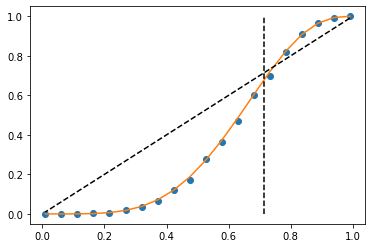

In [207]:
### sanity check 1
plt.plot(1-p_list,succ_prob,"o")
f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-2/7
plt.plot([x0,x0],[0,1],"k--")

#### Sanity check 2: 5-qubit code

In [229]:
### [[5,1,3]]-code
### whether work for non-CSS codes (multilayers???) one-layer sanity check.
H_XZ = np.array([[1,0,0,1,0,0,1,1,0,0],
               [0,1,0,0,1,0,0,1,1,0],
               [1,0,1,0,0,0,0,0,1,1],
               [0,1,0,1,0,1,0,0,0,1]], dtype = int)

n=5
N = 5 # number of data qubits 
Ns = 4 # number of stabilizers
r=4
k = 1

logicals_X = logical_from_Hparity(H_XZ, N, k, Ns)[0]
logicals_Z = logical_from_Hparity(H_XZ, N, k, Ns)[1]

#print(logicals_X)
#print(logicals_Z)

Sx_mat = H_XZ[0:4,0:n]
Sz_mat = H_XZ[0:4,n:2*n]
#print(Sx_mat)

[[0 0 0 0 1 1 0 0 1 0]]
[[0 0 0 0 0 1 1 1 1 1]]
[[1 0 0 1 0]
 [0 1 0 0 1]
 [1 0 1 0 0]
 [0 1 0 1 0]]


In [230]:
## construct stabilizer graph
B_orig = nx.Graph()
B_orig.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig.add_nodes_from(s_nodes)
for row in range(np.size(Sx_mat,0)):
    qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
    B_orig.add_edges_from([("s%d" % row, q) for q in qs])

#nx.draw(B_orig,  with_labels=True)
#plt.show()
# logical = np.ones(N)
#logical_t = logicals_X[:,0:n]
#print(logical_t)
logical_x = np.array([[1,1,1,1,1]],dtype=int)

p_list = np.linspace(0.01,0.99,20)
Nrep = 2000 # number of MC iterations
succ_prob = np.zeros(len(p_list))

for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        for log_i in range(len(logical_t)):
            logical = logical_t[log_i]
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob[i_p] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
            
succ_prob /= (Nrep*k)

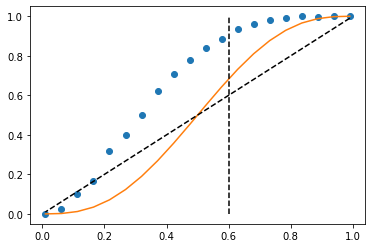

In [235]:
### sanity check 1
plt.plot(1-p_list,succ_prob,"o")
f = lambda x: x**5 + 5*x**4*(1-x) + 10*x**3*(1-x)**2
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-2/5
plt.plot([x0,x0],[0,1],"k--")

#### Sanity check 3: toric codes

## multi-layer

In [ ]:
# original: 
Sx_mat = np.array([[1,1,1,1,0,0,0],\
              [1,1,0,0,1,1,0],\
              [1,0,1,0,1,0,1]])
H_XZ = np.array([[1,1,1,1,0,0,0,0,0,0,0,0,0,0],\
                [1,1,0,0,1,1,0,0,0,0,0,0,0,0],\
                [1,0,1,0,1,0,1,0,0,0,0,0,0,0],\
                [0,0,0,0,0,0,0,1,1,1,1,0,0,0],\
                [0,0,0,0,0,0,0,1,1,0,0,1,1,0],\
                [0,0,0,0,0,0,0,1,0,1,0,1,0,1]])
n = 7
k = 1
r = 3
Sx_mat = H_XZ[:, 0:n]
Sx_mat = Sx_mat[~np.all(Sx_mat == 0, axis=1)]
print(Sx_mat)
Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer
logicals_X = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[0]
logicals_Z = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[1]
logical_t = logicals_X[:,0:Nq_l]

Nl_list = np.arange(2,5) # number of layers
p_list = np.linspace(0.01,0.4,20) # list of loss probability
Nrep = 2000 # number of MC iterations
succ_prob_7q = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    pos = dict()
    for q in range(N):
        x = q%(Nq_l+Ns_l)
        y = int(q/(Nq_l+Ns_l))
        if x >= Nq_l:
            pos[q] = (2*(x-4)-4.8,y+0.7)
        else:
            pos[q] = (x,y)
    for sq in range(Ns):
        x = sq% Ns_l
        y = int(sq/Ns_l)
        pos["s%d" % sq] = (2*x+1,y+0.3)

    nx.draw(B_orig, pos,  with_labels=True)
    plt.show()
    
    for log_i in range(len(logical_t)):
        logical_1l = logical_t[log_i]
        logical = np.zeros(N)
        for i_l in range(Nl):
            logical[i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logical_1l

        for i_p, p in enumerate(p_list):
            for i_rep in range(Nrep):
                loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
                succ_prob_7q[i_p,i_L] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_7q /= (Nrep * k)

## QLPDC parity check matrix generation

In [172]:
## adapted from: stackoverflow...
def gf2_rank(rows):
    """
    Find rank of a matrix over GF2.
    The rows of the matrix are given as nonnegative integers, thought
    of as bit-strings.
    This function modifies the input list. Use gf2_rank(rows.copy())
    instead of gf2_rank(rows) to avoid modifying rows.
    """
    rows_new = []
    rank = 0
    while rows:
        #print(rows)
        pivot_row = rows.pop()
        #print(pivot_row)
        if pivot_row:
            rows_new.append(pivot_row)
            rank += 1
            lsb = pivot_row & -pivot_row
            for index, row in enumerate(rows):
                if row & lsb:
                    rows[index] = row ^ pivot_row
    return (rows_new, rank)

### [[48, 6, 8]]-generalized bicycle (GB) code

In [4]:
## use [[48,6,8]]-generalized bicycle code as an example (l=24)
## l denotes the dim of circulant matrix
## the GB (generalized bicycle codes follow the form: [H_X H_Z] ([[H_X 0],[0 H_Z]]): H_X = [A,B], H_Z = [B^T,A^T]
## A = (a(x)), B = (b(x)); 
## [[48,6,8]]-GB code: 
## a(x) = 1 + x^2 + x^8 + x^15
## b(x) = 1 + x^2 + x^12 + x^17
from numpy.linalg import matrix_power
from numpy.linalg import matrix_rank
l = 24
P_l = np.zeros((l,l),dtype=int)
P_l[0,l-1] = 1
P_l[1:l,0:l-1] = np.eye(l-1, dtype=int)
A_part = (np.eye(l, dtype=int) + matrix_power(P_l,2) + matrix_power(P_l,8) + matrix_power(P_l,15))%2
B_part = (np.eye(l, dtype=int) + matrix_power(P_l,2) + matrix_power(P_l,12) + matrix_power(P_l,17))%2
H_X = np.concatenate((A_part, B_part), axis=1)
H_Z = np.concatenate((np.transpose(B_part), np.transpose(A_part)), axis=1)
H_XZ = np.zeros((2*l,4*l), dtype = int)
H_XZ[0:l, 0:2*l] = H_X
H_XZ[l:2*l, 2*l:4*l] = H_Z
n = 48
k = 6
r = 21

In [5]:
##########
n_row = np.size(H_X,axis=0)
H_Xb = []
H_Zb = []
for i_r in range(n_row):
    H_Xb.append(np.sum(H_X[i_r,:]* 2**np.arange(47,-1,-1)))
    H_Zb.append(np.sum(H_Z[i_r,:]* 2**np.arange(47,-1,-1)))
print(H_Xb)
print(H_Zb)

[141014555756546, 70507277878273, 175991127294464, 87995563647232, 43997781823616, 21998890911808, 10999445455904, 5499722727952, 143487341330696, 71743670665348, 35871835332674, 17935917666337, 8967967221776, 4483983610888, 2241991805444, 141858475869442, 70929237934721, 35464627355968, 17732313677984, 8866156838992, 4433078419496, 2216539209748, 1108269604874, 554134802437]
[175957304443136, 87978652221568, 43989326110784, 21994663055392, 10997331527696, 5498665763848, 2749332881924, 142112146407682, 71056073203841, 35528044990528, 17764022495264, 8882011247632, 145178485590536, 72589242795268, 36294621397634, 18147310698817, 9073663738016, 4536831869008, 2268415934504, 1134207967252, 567103983626, 283551991813, 140879264351234, 70439632175617]


In [183]:
H_Xbc = H_Xb.copy()
H_Zbc = H_Zb.copy()
H_Xb1, RoX = gf2_rank(H_Xbc)
H_Zb1, RoZ = gf2_rank(H_Zbc)
print(RoX)
print(RoZ)
print(len(H_Xb1))
print(len(H_Zb1))

21
21
21
21


In [184]:
## transform back to the binary matrix:
def Hb_to_H(n,r,H_list):
    H_tot = []
    for i in range(r):
        H_row = []
        H_num = H_list[i]
        for k in range(n-1,-1,-1):
            H_row.append(H_num // (2**k))
            H_num = H_num % (2**k)
        H_tot.append(H_row)
    H_new = np.array(H_tot)
    return H_new

H_X_new = Hb_to_H(48,21,H_Xb1)
H_Z_new = Hb_to_H(48,21,H_Zb1)
print(H_X_new, H_X_new.shape)
print(H_Z_new, H_Z_new.shape)
H_XZ = np.zeros((2*r,4*l), dtype = int)
H_XZ[0:r, 0:2*l] = H_X_new
H_XZ[r:2*r, 2*l:4*l] = H_Z_new

[[1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]] (21, 48)
[[1 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]] (21, 48)


### (3,4)-regular code

In [80]:
### regular (3,4) LDPC codes, change into QLPDC codes?
H_X = np.array([[1,0,1,1,0,0,0,0,0,0,1,0],\
               [1,1,0,0,1,0,0,0,0,0,0,1],\
               [0,1,1,0,0,1,0,0,0,1,0,0],\
               [0,1,0,1,0,0,0,0,1,0,1,0],\
               [0,0,1,0,1,0,1,0,0,0,0,1],\
               [1,0,0,0,0,1,0,1,0,1,0,0],\
               [0,0,0,0,0,1,1,1,0,0,0,1],\
               [0,0,0,1,0,0,0,1,1,1,0,0],\
               [0,0,0,0,1,0,1,0,1,0,1,0]])

In [185]:
# have both X and Z calculation
# in layer stabilizer group
Sx_mat = H_XZ[:, 0:n]
Sx_mat = Sx_mat[~np.all(Sx_mat == 0, axis=1)]
Sz_mat = H_XZ[:, n:2*n]
Sz_mat = Sz_mat[~np.all(Sz_mat == 0, axis=1)]
Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer
logicals_X = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[0]
logicals_Z = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[1]
logical_tX = logicals_X[:,0:Nq_l]
logical_tZ = logicals_Z[:,Nq_l:2*Nq_l]

Nl_list = np.arange(2,5) # number of layers
p_list = np.linspace(0.01,0.4,20) # list of loss probability
Nrep = 2000 # number of MC iterations
succ_prob_X = np.zeros((len(p_list),len(Nl_list)))
succ_prob_Z = np.zeros((len(p_list),len(Nl_list)))
succ_prob_tot = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
    
    '''
    pos = dict()
    for q in range(N):
        x = q%(Nq_l+Ns_l)
        y = int(q/(Nq_l+Ns_l))
        if x >= Nq_l:
            pos[q] = (2*(x-4)-4.8,y+0.7)
        else:
            pos[q] = (x,y)
    for sq in range(Ns):
        x = sq% Ns_l
        y = int(sq/Ns_l)
        pos["s%d" % sq] = (2*x+1,y+0.3)

    nx.draw(B_orig, pos,  with_labels=True)
    plt.show()
    '''
    
    for log_i in range(len(logical_tX)):
        logical_1l = logical_tX[log_i]
        logical = np.zeros(N)
        for i_l in range(Nl):
            logical[i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logical_1l

        for i_p, p in enumerate(p_list):
            for i_rep in range(Nrep):
                loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
                succ_prob_X[i_p,i_L] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
    
    for log_i in range(len(logical_tZ)):
        logical_1l = logical_tZ[log_i]
        logical = np.zeros(N)
        for i_l in range(Nl):
            logical[i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logical_1l

        for i_p, p in enumerate(p_list):
            for i_rep in range(Nrep):
                loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
                succ_prob_Z[i_p,i_L] += succ_prob_calc(B_orig, logical, s_nodes, loss_inds)
    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_X /= (Nrep * k)
succ_prob_Z /= (Nrep * k)

finished L = 2 in 22892.7 secs
finished L = 3 in 53860.1 secs
finished L = 4 in 101516.2 secs


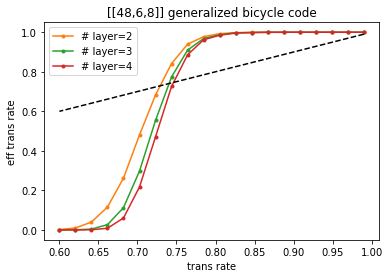

In [193]:
#f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
f = lambda x: x**5 + 5*x**4*(1-x) + 10*x**3*(1-x)**2
#plt.plot(1-p_list,f(1-p_list),"-",label="1-layer Analytical")
succ_prob_tot = np.multiply(succ_prob_X, succ_prob_Z)
for i_L, L in enumerate(Nl_list):
    #plt.plot(1-p_list,succ_prob_7q[:,i_L],".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)
    plt.plot(1-p_list,succ_prob_tot[:,i_L],".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)
plt.plot(1-p_list,1-p_list,"k--")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.title('[[48,6,8]] generalized bicycle code')
#plt.savefig("48q6l_pdata.pdf")
plt.show()

In [194]:
print(succ_prob_tot)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [9.99916667e-01 9.99916667e-01 9.99916667e-01]
 [9.99833340e-01 9.99833340e-01 9.99750014e-01]
 [9.99333417e-01 9.98417292e-01 9.98583750e-01]
 [9.98084250e-01 9.97168229e-01 9.95754500e-01]
 [9.92763000e-01 9.87373444e-01 9.84890812e-01]
 [9.77544028e-01 9.67927854e-01 9.61870312e-01]
 [9.39445451e-01 9.09559542e-01 8.85559333e-01]
 [8.41576750e-01 7.73959063e-01 7.25916861e-01]
 [6.82883681e-01 5.54340403e-01 4.71049771e-01]
 [4.80764722e-01 2.97762083e-01 2.17544444e-01]
 [2.62060694e-01 1.12779333e-01 6.03380486e-02]
 [1.15684875e-01 2.66317083e-02 8.48925000e-03]
 [3.97435000e-02 4.19255556e-03 7.18250000e-04]
 [9.94270833e-03 3.97708333e-04 3.35833333e-05]
 [1.93322222e-03 3.44722222e-05 6.80555556e-07]]


In [195]:
# write data in a file.
np.savetxt('48q6l_pdata.txt', succ_prob_tot, delimiter=',')

In [197]:
#print(succ_prob_X)
#print(succ_prob_Z)

## Example 2: Toric code

In [64]:
L_list = np.arange(4,12,2) # linear dim of toric code
p_list = np.linspace(0.01,0.99,20)
Nrep = 200
succ_prob_tc = np.zeros((len(p_list),len(L_list)))

for i_L, L in enumerate(L_list):
    tic = time.time()
    
    r1 = L
    r2 = L
    N = 2*r1*r2 # number of data qubits
    Ns = r1*r2 # number of stabilizers

    Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
    pos = dict()
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
            pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
            pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
            pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
            pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
            pos[2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)#, bipartite=1)
    for row in range(np.size(Sx,0)):
        qs = np.argwhere(Sx[row,:]>0)[:,0]
        B_orig.add_edges_from([("s%d" % row, q) for q in qs])

    logicals = np.zeros((2,2*r1*r2))
    logicals[0,1:2*r1:2] = np.ones(r1) 
    logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob_tc[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
           
    toc = time.time()
    print("finished L = %d in %.1f secs" % (L,toc-tic))

succ_prob_tc /= Nrep


finished L = 4 in 13.6 secs
finished L = 6 in 52.4 secs
finished L = 8 in 149.4 secs
finished L = 10 in 357.0 secs


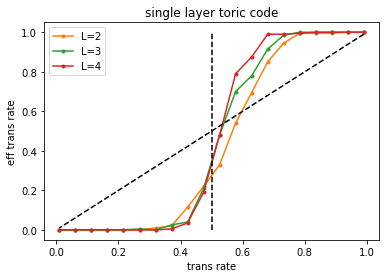

In [65]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_tc[:,i_L],".-", color ="C%d" % (i_L+1), label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
x0 = 0.5  # percolation threshold
plt.plot([x0,x0],[0,1],"k--")
plt.title("single layer toric code")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()

## foliated toric code

In [ ]:
Nl_list = np.arange(4,8)
p_list = np.linspace(0.15,0.35,8)
Nrep = 400
succ_prob_3dtc = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    
    r1, r2 = Nl, Nl
    # in layer stabilizer group
    Sx_mat = np.zeros((r1*r2,2*r1*r2),dtype=int)
    for i_y in range(r2):
        for i_x in range(r1):
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx_mat[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1

    Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
    Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer

    # Nl: number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    logicals_l = np.zeros((2,2*r1*r2))
    logicals_l[0,1:2*r1:2] = np.ones(r1) 
    logicals_l[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    logicals = np.zeros((2,N))
    for i_l in range(Nl):
        logicals[:,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logicals_l

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])        
            succ_prob_3dtc[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)

    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_3dtc /= Nrep

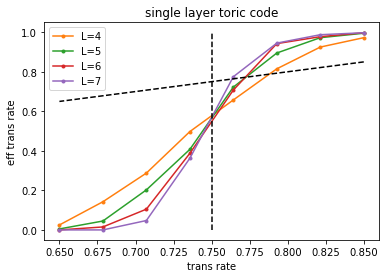

In [6]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_3dtc[:,i_L],".-", color ="C%d" % (i_L+1), label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-0.25  # percolation threshold
plt.plot([x0,x0],[0,1],"k--")
plt.title("single layer toric code")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()